# MNLI - Evaluation Pipeline

**Task**: Natural Language Inference (NLI)  
**Objective**: Comprehensive evaluation on matched/mismatched domains  

---

## Pipeline Overview

1. Environment Setup
2. Load Models & Data
3. Matched vs Mismatched Evaluation
4. Confusion Matrix Analysis
5. Per-Class Performance
6. Inference Benchmarking
7. Generate Report

## 1. Environment Setup

In [8]:
!pip install -q transformers datasets accelerate scikit-learn
!pip install -q matplotlib seaborn pandas numpy

In [9]:
import os
import json
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from collections import Counter

import torch
from torch.utils.data import DataLoader

from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

✅ Using device: cuda


In [10]:
class EvalConfig:
    DATA_DIR = './processed_data'
    MODEL_DIR = './models'
    LOG_DIR = './logs'
    EVAL_DIR = './evaluation'
    
    MODELS = {
        'bert-base': 'mnli_bert-base_best',
        'distilbert': 'mnli_distilbert_best',
        'tinybert': 'mnli_tinybert_best'
    }
    
    BATCH_SIZE = 32

config = EvalConfig()
os.makedirs(config.EVAL_DIR, exist_ok=True)

config_path = os.path.join(config.DATA_DIR, 'mnli_config.json')
with open(config_path, 'r') as f:
    data_config = json.load(f)

LABEL_NAMES = data_config['label_names']
NUM_LABELS = data_config['num_labels']

print(f"📋 Configuration loaded!")
print(f"   Labels: {LABEL_NAMES}")

📋 Configuration loaded!
   Labels: ['entailment', 'neutral', 'contradiction']


## 2. Load Models & Data

In [11]:
print("📥 Loading test datasets...")

dataset_path = os.path.join(config.DATA_DIR, 'mnli_tokenized')
dataset = load_from_disk(dataset_path)

test_matched = dataset['test_matched']
test_mismatched = dataset['test_mismatched']

print(f"✅ Test datasets loaded:")
print(f"   Matched: {len(test_matched):,} samples")
print(f"   Mismatched: {len(test_mismatched):,} samples")

📥 Loading test datasets...
✅ Test datasets loaded:
   Matched: 9,815 samples
   Mismatched: 9,832 samples


In [12]:
def load_model(model_name):
    model_path = os.path.join(config.MODEL_DIR, config.MODELS[model_name])
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()
    return model, tokenizer

print("📦 Loading models...")
models = {}
tokenizers = {}

for model_name in config.MODELS.keys():
    try:
        models[model_name], tokenizers[model_name] = load_model(model_name)
        print(f"   ✅ {model_name} loaded")
    except Exception as e:
        print(f"   ❌ {model_name} not found: {e}")

print(f"\n✅ Loaded {len(models)} models")

📦 Loading models...
   ✅ bert-base loaded
   ✅ distilbert loaded
   ✅ tinybert loaded

✅ Loaded 3 models


## 3. Matched vs Mismatched Evaluation

In [13]:
@torch.no_grad()
def get_predictions(model, dataset, batch_size=32):
    """Get predictions for a dataset."""
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label']
        
        try:
            if 'token_type_ids' in batch and hasattr(model.config, 'type_vocab_size'):
                token_type_ids = batch['token_type_ids'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            else:
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        except TypeError:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        probs = torch.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(outputs.logits, dim=-1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())
    
    return {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs)
    }

print("✅ Prediction function defined")

✅ Prediction function defined


In [14]:
print("🔄 Evaluating models...")

results = {}

for model_name, model in models.items():
    print(f"\n   {model_name}:")
    results[model_name] = {
        'matched': get_predictions(model, test_matched, config.BATCH_SIZE),
        'mismatched': get_predictions(model, test_mismatched, config.BATCH_SIZE)
    }
    print(f"      Matched: {len(results[model_name]['matched']['predictions'])} samples")
    print(f"      Mismatched: {len(results[model_name]['mismatched']['predictions'])} samples")

print("\n✅ All evaluations complete!")

🔄 Evaluating models...

   bert-base:
      Matched: 9815 samples
      Mismatched: 9832 samples

   distilbert:
      Matched: 9815 samples
      Mismatched: 9832 samples

   tinybert:
      Matched: 9815 samples
      Mismatched: 9832 samples

✅ All evaluations complete!


In [15]:
def compute_metrics(y_true, y_pred):
    """Compute classification metrics."""
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro')
    }

all_metrics = {}

for model_name in results.keys():
    all_metrics[model_name] = {}
    
    for split in ['matched', 'mismatched']:
        y_true = results[model_name][split]['labels']
        y_pred = results[model_name][split]['predictions']
        all_metrics[model_name][split] = compute_metrics(y_true, y_pred)

In [16]:
print("\n📊 Model Performance Comparison:")
print("="*90)

comparison_data = []
for model_name in all_metrics.keys():
    for split in ['matched', 'mismatched']:
        m = all_metrics[model_name][split]
        comparison_data.append({
            'Model': model_name,
            'Split': split,
            'Accuracy': m['accuracy'],
            'F1 Macro': m['f1_macro'],
            'Precision': m['precision_macro'],
            'Recall': m['recall_macro']
        })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(4).to_string(index=False))


📊 Model Performance Comparison:
     Model      Split  Accuracy  F1 Macro  Precision  Recall
 bert-base    matched    0.7956    0.7950     0.7956  0.7951
 bert-base mismatched    0.8021    0.8016     0.8024  0.8016
distilbert    matched    0.7509    0.7500     0.7502  0.7502
distilbert mismatched    0.7606    0.7597     0.7599  0.7598
  tinybert    matched    0.7833    0.7811     0.7823  0.7815
  tinybert mismatched    0.7819    0.7795     0.7813  0.7796


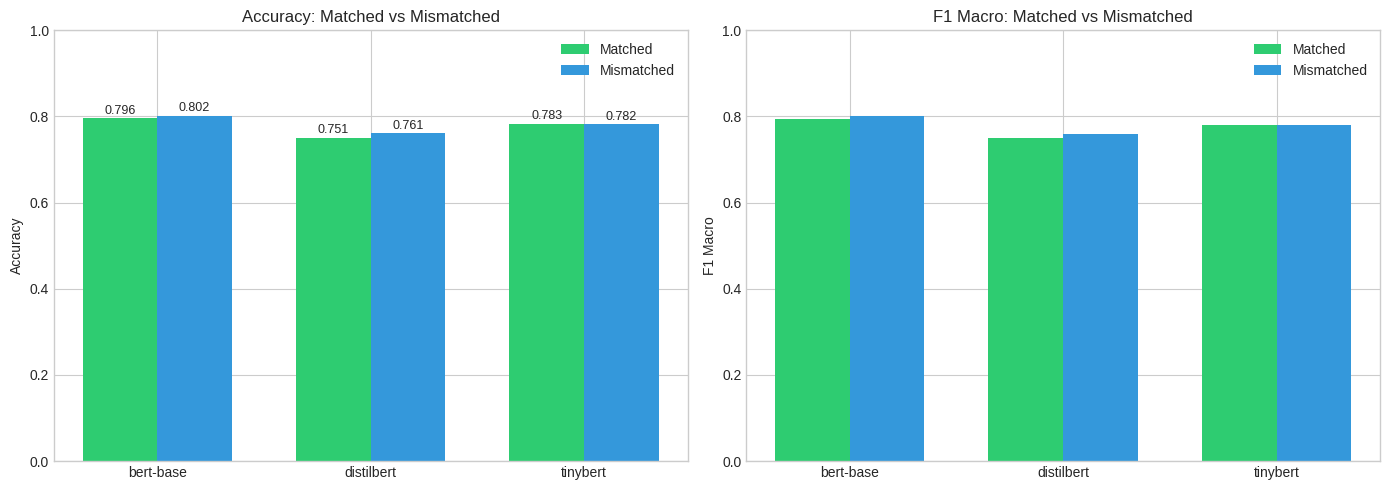

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models_list = list(all_metrics.keys())
x = np.arange(len(models_list))
width = 0.35

matched_acc = [all_metrics[m]['matched']['accuracy'] for m in models_list]
mismatched_acc = [all_metrics[m]['mismatched']['accuracy'] for m in models_list]

bars1 = axes[0].bar(x - width/2, matched_acc, width, label='Matched', color='#2ecc71')
bars2 = axes[0].bar(x + width/2, mismatched_acc, width, label='Mismatched', color='#3498db')

axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy: Matched vs Mismatched')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_list)
axes[0].legend()
axes[0].set_ylim(0, 1)

for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{bar.get_height():.3f}', ha='center', fontsize=9)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{bar.get_height():.3f}', ha='center', fontsize=9)

matched_f1 = [all_metrics[m]['matched']['f1_macro'] for m in models_list]
mismatched_f1 = [all_metrics[m]['mismatched']['f1_macro'] for m in models_list]

bars3 = axes[1].bar(x - width/2, matched_f1, width, label='Matched', color='#2ecc71')
bars4 = axes[1].bar(x + width/2, mismatched_f1, width, label='Mismatched', color='#3498db')

axes[1].set_ylabel('F1 Macro')
axes[1].set_title('F1 Macro: Matched vs Mismatched')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models_list)
axes[1].legend()
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(config.EVAL_DIR, 'matched_vs_mismatched.png'), dpi=150, bbox_inches='tight')
plt.show()

## 4. Confusion Matrix Analysis

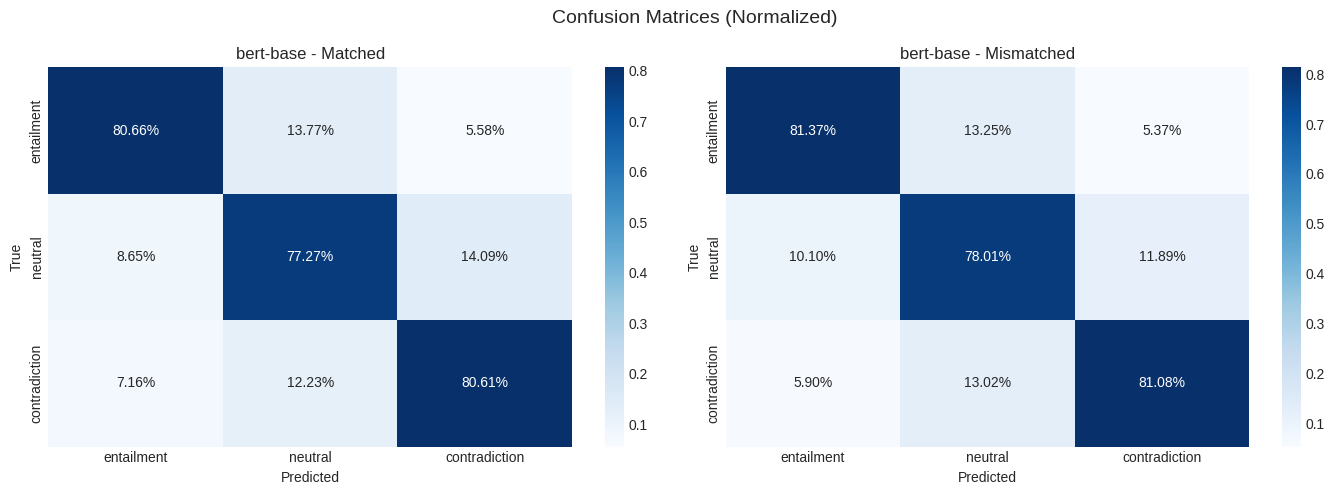

In [18]:
best_model = max(all_metrics.keys(), key=lambda m: all_metrics[m]['matched']['accuracy'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, split in zip(axes, ['matched', 'mismatched']):
    y_true = results[best_model][split]['labels']
    y_pred = results[best_model][split]['predictions']
    
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt='.2%',
        cmap='Blues',
        xticklabels=LABEL_NAMES,
        yticklabels=LABEL_NAMES,
        ax=ax
    )
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{best_model} - {split.capitalize()}')

plt.suptitle('Confusion Matrices (Normalized)', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(config.EVAL_DIR, 'confusion_matrices.png'), dpi=150, bbox_inches='tight')
plt.show()

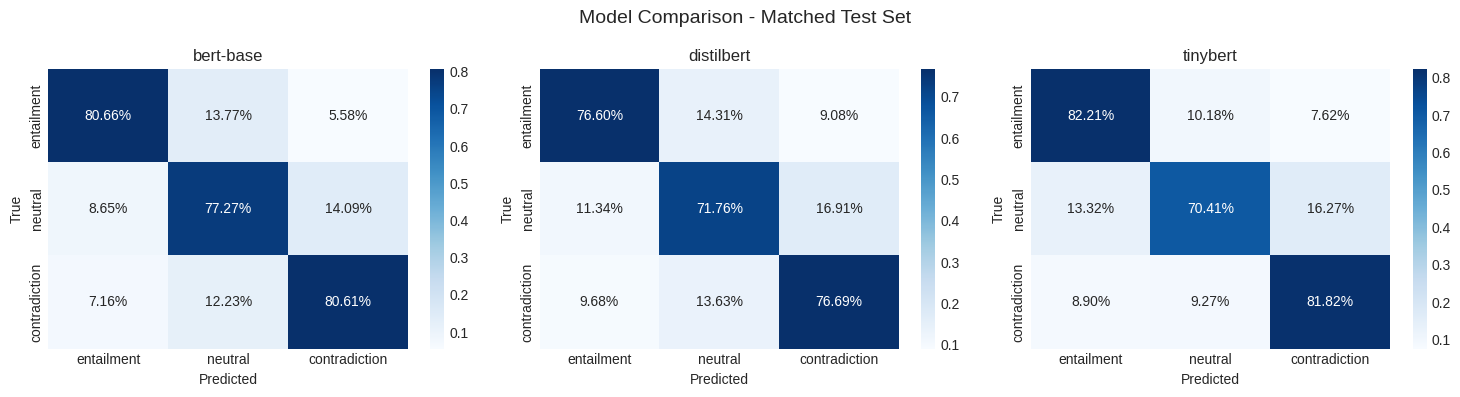

In [19]:
fig, axes = plt.subplots(1, len(models), figsize=(5*len(models), 4))
if len(models) == 1:
    axes = [axes]

for ax, model_name in zip(axes, models.keys()):
    y_true = results[model_name]['matched']['labels']
    y_pred = results[model_name]['matched']['predictions']
    
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt='.2%',
        cmap='Blues',
        xticklabels=LABEL_NAMES,
        yticklabels=LABEL_NAMES,
        ax=ax
    )
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{model_name}')

plt.suptitle('Model Comparison - Matched Test Set', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(config.EVAL_DIR, 'model_confusion_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

## 5. Per-Class Performance

In [20]:
print(f"\n📊 Classification Report ({best_model} - Matched):")
print("="*70)

y_true = results[best_model]['matched']['labels']
y_pred = results[best_model]['matched']['predictions']

print(classification_report(y_true, y_pred, target_names=LABEL_NAMES, digits=4))


📊 Classification Report (bert-base - Matched):
               precision    recall  f1-score   support

   entailment     0.8488    0.8066    0.8271      3479
      neutral     0.7346    0.7727    0.7531      3123
contradiction     0.8033    0.8061    0.8047      3213

     accuracy                         0.7956      9815
    macro avg     0.7956    0.7951    0.7950      9815
 weighted avg     0.7976    0.7956    0.7962      9815



In [21]:
def compute_per_class_f1(y_true, y_pred, label_names):
    f1_scores = f1_score(y_true, y_pred, average=None)
    return {label: f1 for label, f1 in zip(label_names, f1_scores)}

per_class_data = []
for model_name in models.keys():
    for split in ['matched', 'mismatched']:
        y_true = results[model_name][split]['labels']
        y_pred = results[model_name][split]['predictions']
        
        f1_per_class = compute_per_class_f1(y_true, y_pred, LABEL_NAMES)
        
        for label, f1 in f1_per_class.items():
            per_class_data.append({
                'Model': model_name,
                'Split': split,
                'Class': label,
                'F1': f1
            })

per_class_df = pd.DataFrame(per_class_data)

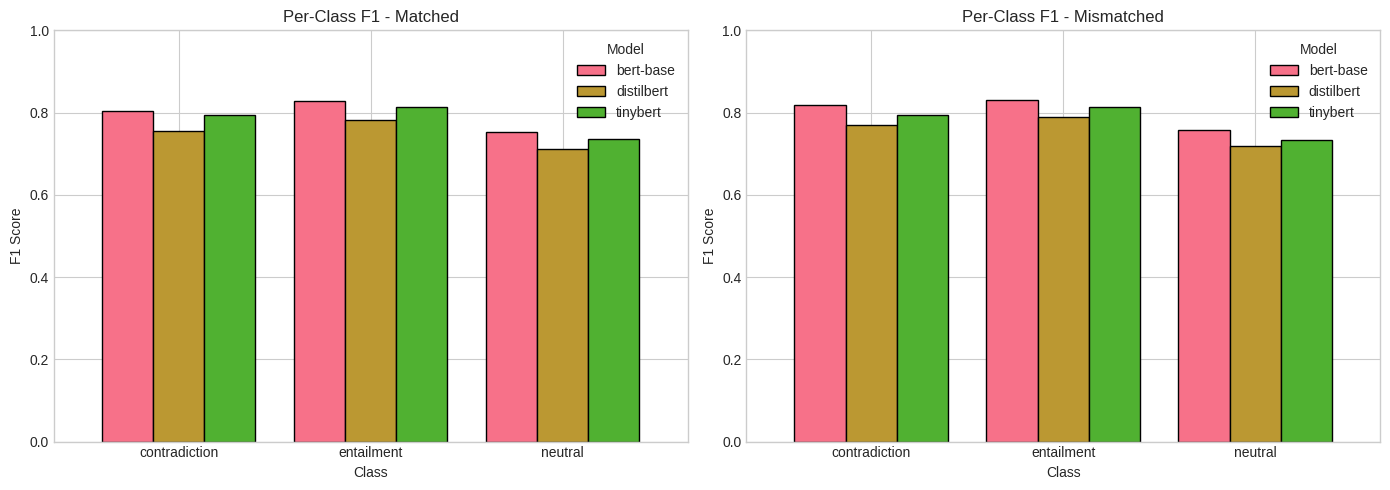

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, split in zip(axes, ['matched', 'mismatched']):
    split_data = per_class_df[per_class_df['Split'] == split]
    pivot = split_data.pivot(index='Class', columns='Model', values='F1')
    
    pivot.plot(kind='bar', ax=ax, width=0.8, edgecolor='black')
    ax.set_xlabel('Class')
    ax.set_ylabel('F1 Score')
    ax.set_title(f'Per-Class F1 - {split.capitalize()}')
    ax.legend(title='Model')
    ax.set_ylim(0, 1)
    plt.setp(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(config.EVAL_DIR, 'per_class_f1.png'), dpi=150, bbox_inches='tight')
plt.show()

## 6. Inference Benchmarking

In [23]:
@torch.no_grad()
def benchmark_inference(model, dataset, num_samples=500, warmup_runs=10, benchmark_runs=50):
    """Benchmark inference speed."""
    model.eval()
    
    sample_data = dataset.select(range(min(num_samples, len(dataset))))
    input_ids = torch.tensor(np.array(sample_data['input_ids'])).to(device)
    attention_mask = torch.tensor(np.array(sample_data['attention_mask'])).to(device)
    
    use_token_type = 'token_type_ids' in sample_data.features and hasattr(model.config, 'type_vocab_size')
    if use_token_type:
        token_type_ids = torch.tensor(np.array(sample_data['token_type_ids'])).to(device)
    
    for _ in range(warmup_runs):
        try:
            if use_token_type:
                _ = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            else:
                _ = model(input_ids=input_ids, attention_mask=attention_mask)
        except TypeError:
            _ = model(input_ids=input_ids, attention_mask=attention_mask)
            use_token_type = False
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
    
    times = []
    for _ in range(benchmark_runs):
        start = time.perf_counter()
        try:
            if use_token_type:
                _ = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            else:
                _ = model(input_ids=input_ids, attention_mask=attention_mask)
        except TypeError:
            _ = model(input_ids=input_ids, attention_mask=attention_mask)
        if device.type == 'cuda':
            torch.cuda.synchronize()
        times.append(time.perf_counter() - start)
    
    times = np.array(times)
    
    return {
        'mean_time_ms': times.mean() * 1000,
        'std_time_ms': times.std() * 1000,
        'samples_per_second': num_samples / times.mean(),
        'ms_per_sample': (times.mean() * 1000) / num_samples
    }

print("⏱️ Benchmarking inference speed...")

benchmark_results = {}
for model_name, model in models.items():
    print(f"   Benchmarking {model_name}...")
    benchmark_results[model_name] = benchmark_inference(model, test_matched)

print("\n✅ Benchmarking complete!")

⏱️ Benchmarking inference speed...
   Benchmarking bert-base...
   Benchmarking distilbert...
   Benchmarking tinybert...

✅ Benchmarking complete!


In [24]:
benchmark_df = pd.DataFrame([
    {
        'Model': name,
        'Samples/sec': f"{res['samples_per_second']:.1f}",
        'ms/sample': f"{res['ms_per_sample']:.3f}",
        'Mean Time (ms)': f"{res['mean_time_ms']:.2f}"
    }
    for name, res in benchmark_results.items()
])

print("\n⏱️ Inference Speed Comparison:")
print(benchmark_df.to_string(index=False))


⏱️ Inference Speed Comparison:
     Model Samples/sec ms/sample Mean Time (ms)
 bert-base       157.2     6.361        3180.44
distilbert       310.4     3.222        1611.04
  tinybert      1967.3     0.508         254.16


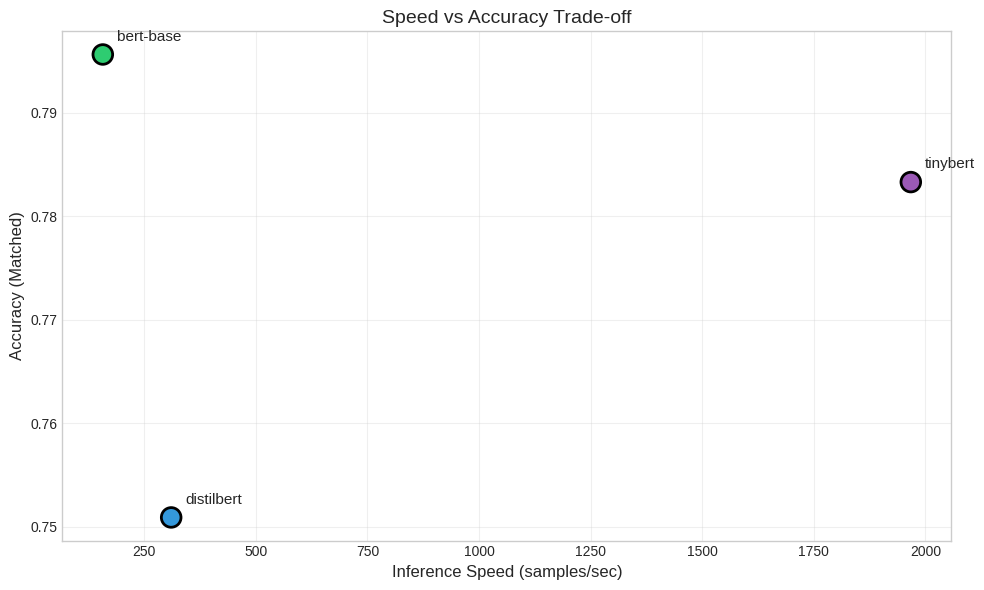

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#2ecc71', '#3498db', '#9b59b6']
accuracies = [all_metrics[m]['matched']['accuracy'] for m in models.keys()]
speeds = [benchmark_results[m]['samples_per_second'] for m in models.keys()]

scatter = ax.scatter(speeds, accuracies, s=200, c=colors[:len(models)], edgecolor='black', linewidth=2)

for i, (name, speed, acc) in enumerate(zip(models.keys(), speeds, accuracies)):
    ax.annotate(name, (speed, acc), xytext=(10, 10), textcoords='offset points', fontsize=11)

ax.set_xlabel('Inference Speed (samples/sec)', fontsize=12)
ax.set_ylabel('Accuracy (Matched)', fontsize=12)
ax.set_title('Speed vs Accuracy Trade-off', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.EVAL_DIR, 'speed_accuracy_tradeoff.png'), dpi=150, bbox_inches='tight')
plt.show()

## 7. Generate Report

In [26]:
evaluation_report = {
    'dataset': 'MNLI',
    'task': 'Natural Language Inference',
    'num_labels': NUM_LABELS,
    'label_names': LABEL_NAMES,
    'test_samples': {
        'matched': len(test_matched),
        'mismatched': len(test_mismatched)
    },
    'models': {}
}

for model_name in models.keys():
    evaluation_report['models'][model_name] = {
        'metrics': all_metrics[model_name],
        'benchmark': benchmark_results[model_name]
    }

report_path = os.path.join(config.EVAL_DIR, 'evaluation_report.json')
with open(report_path, 'w') as f:
    json.dump(evaluation_report, f, indent=2, default=float)

print(f"✅ Report saved to: {report_path}")

✅ Report saved to: ./evaluation/evaluation_report.json


In [27]:
print("\n" + "="*80)
print("📋 MNLI EVALUATION SUMMARY")
print("="*80)

print(f"\n📊 Dataset: {evaluation_report['dataset']}")
print(f"📋 Task: {evaluation_report['task']}")
print(f"🏷️ Labels: {evaluation_report['label_names']}")
print(f"📝 Test Samples (Matched): {evaluation_report['test_samples']['matched']:,}")
print(f"📝 Test Samples (Mismatched): {evaluation_report['test_samples']['mismatched']:,}")

print("\n" + "-"*80)
print("🏆 MODEL COMPARISON")
print("-"*80)

for model_name, data in evaluation_report['models'].items():
    matched = data['metrics']['matched']
    mismatched = data['metrics']['mismatched']
    
    print(f"\n   {model_name.upper()}:")
    print(f"   • Matched Accuracy: {matched['accuracy']:.4f}")
    print(f"   • Mismatched Accuracy: {mismatched['accuracy']:.4f}")
    print(f"   • F1 Macro (Matched): {matched['f1_macro']:.4f}")
    print(f"   • Speed: {data['benchmark']['samples_per_second']:.1f} samples/sec")

print("\n" + "="*80)
print("✅ Evaluation Complete!")


📋 MNLI EVALUATION SUMMARY

📊 Dataset: MNLI
📋 Task: Natural Language Inference
🏷️ Labels: ['entailment', 'neutral', 'contradiction']
📝 Test Samples (Matched): 9,815
📝 Test Samples (Mismatched): 9,832

--------------------------------------------------------------------------------
🏆 MODEL COMPARISON
--------------------------------------------------------------------------------

   BERT-BASE:
   • Matched Accuracy: 0.7956
   • Mismatched Accuracy: 0.8021
   • F1 Macro (Matched): 0.7950
   • Speed: 157.2 samples/sec

   DISTILBERT:
   • Matched Accuracy: 0.7509
   • Mismatched Accuracy: 0.7606
   • F1 Macro (Matched): 0.7500
   • Speed: 310.4 samples/sec

   TINYBERT:
   • Matched Accuracy: 0.7833
   • Mismatched Accuracy: 0.7819
   • F1 Macro (Matched): 0.7811
   • Speed: 1967.3 samples/sec

✅ Evaluation Complete!
